Updated analysis incorporating advise from coauthors.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
import lightkurve as lk
from astropy.timeseries import LombScargle
import scipy.signal as signal

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [4]:
tessfits = glob.glob('tess_fits_files/*fits')
tessfits

['tess_fits_files/tess2019226182529-s0015-0000000259773610-0151-s_lc.fits',
 'tess_fits_files/tess2019253231442-s0016-0000000259773610-0152-s_lc.fits']

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


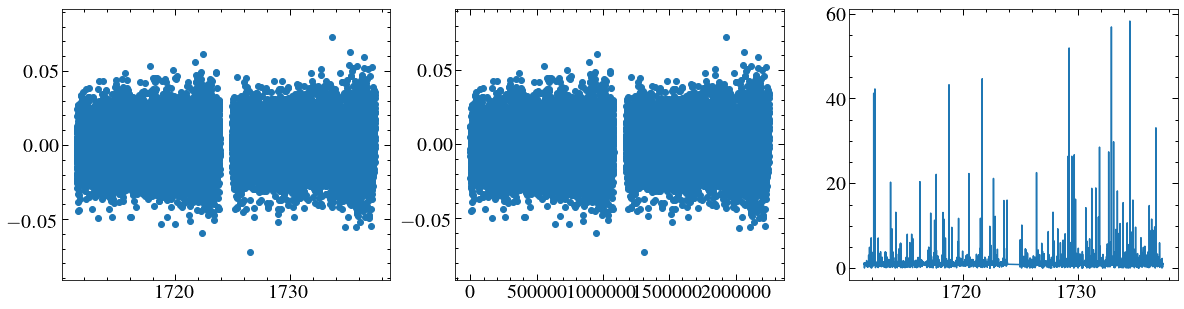

In [47]:
hdul = fits.open(tessfits[0])
data = hdul[1].data
plt.figure(figsize=(20, 5))

plt.subplot(131)
t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
crowdsap = hdul[1].header['CROWDSAP']
#f /= crowdsap
t, f, e = t[q==0], f[q==0], e[q==0]
fit = np.polyval((np.polyfit(t,f,2)), t)
f = (f/fit)-1
e = (e/fit)-1
plt.scatter(t,f)

plt.subplot(132)
jjt, jjf, jje = np.loadtxt('GD394.go.lc1', unpack=True)
plt.scatter(jjt, jjf)

plt.subplot(133)
plt.plot(t, abs(f)/abs(jjf))
plt.show()
#hdul.close()

Differences are probably in the fit? Or the other thing JJ mentioned?  

Let's look at the background.

In [48]:
data.names

['TIME',
 'TIMECORR',
 'CADENCENO',
 'SAP_FLUX',
 'SAP_FLUX_ERR',
 'SAP_BKG',
 'SAP_BKG_ERR',
 'PDCSAP_FLUX',
 'PDCSAP_FLUX_ERR',
 'QUALITY',
 'PSF_CENTR1',
 'PSF_CENTR1_ERR',
 'PSF_CENTR2',
 'PSF_CENTR2_ERR',
 'MOM_CENTR1',
 'MOM_CENTR1_ERR',
 'MOM_CENTR2',
 'MOM_CENTR2_ERR',
 'POS_CORR1',
 'POS_CORR2']

/home/david/anaconda3/lib/python3.7/site-packages/lightkurve/lightcurve.py:108: LightkurveWarning: LightCurve object contains NaN times
  warnings.warn('LightCurve object contains NaN times', LightkurveWarning)


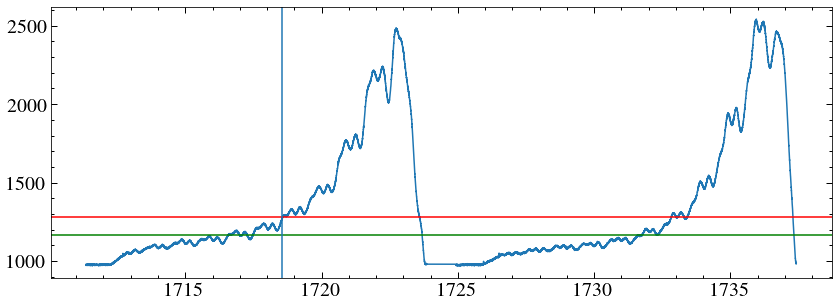

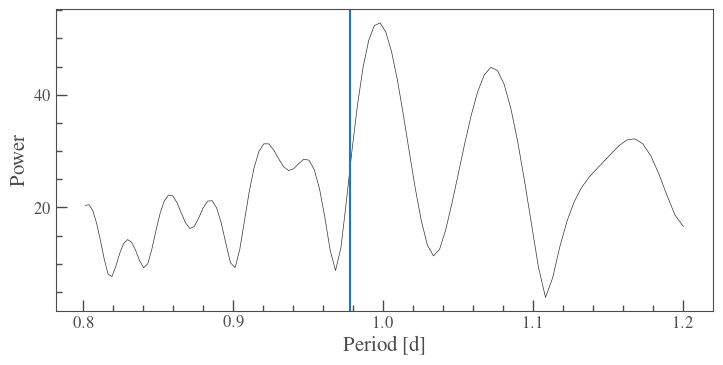

0.9977675262794609 d


/home/david/anaconda3/lib/python3.7/site-packages/lightkurve/lightcurve.py:108: LightkurveWarning: LightCurve object contains NaN times
  warnings.warn('LightCurve object contains NaN times', LightkurveWarning)


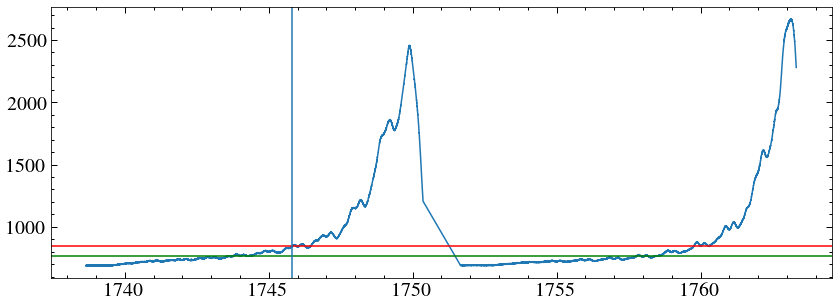

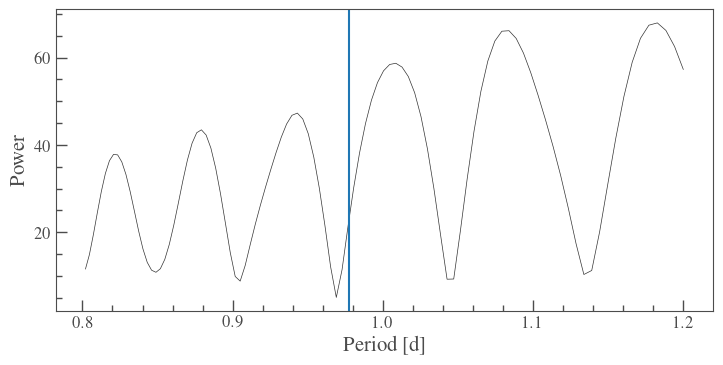

1.1827382285254915 d


In [70]:
cut_times = []#times where bg > 1.1*median bg
for i, ft in enumerate(tessfits):
    data = fits.getdata(ft, 1)
    lc = lk.LightCurve(time=data['TIME'], flux= data['SAP_BKG'])
    lc = lc.remove_nans()
    plt.plot(lc.time, lc.flux)
    plt.axhline(np.median(lc.flux), c='g')
    plt.axhline(1.1*np.median(lc.flux), c='r')
    tind = np.where(lc.flux > 1.1*np.median(lc.flux))[0][0]
    plt.axvline(lc.time[tind])
    
    plt.show()
    
    pg = lc.to_periodogram(oversample_factor=10,minimum_period=0.8*u.day, maximum_period=1.2*u.day)
    pg.plot()
    plt.axvline(0.9776875854871951)
    plt.show()
    print(pg.period_at_max_power)